## Numpy Preprocessing Validation

In [5]:
import numpy as np
import pandas as pd
import pydicom
import cv2
from scipy.ndimage import zoom
from sklearn import preprocessing
from glob import glob
import re
import sqlite3
import matplotlib.pyplot as plt

In [6]:
def string_to_list(string_repr):
    return eval(string_repr)

In [7]:
def window_converter(image, window_width=400, window_level=50):      
    img_min = window_level - window_width // 2
    img_max = window_level + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    #image = (image / image.max() * 255).astype(np.float64)
    return window_image

def transform_to_hu(medical_image, image):
    meta_image = pydicom.dcmread(medical_image)
    intercept = meta_image.RescaleIntercept
    slope = meta_image.RescaleSlope
    hu_image = image * slope + intercept
    return hu_image

def standardize_pixel_array(dcm: pydicom.dataset.FileDataset) -> np.ndarray:
    # Correct DICOM pixel_array if PixelRepresentation == 1.
        pixel_array = dcm.pixel_array
        if dcm.PixelRepresentation == 1:
            bit_shift = dcm.BitsAllocated - dcm.BitsStored
            dtype = pixel_array.dtype 
            pixel_array = (pixel_array << bit_shift).astype(dtype) >> bit_shift
        return pixel_array

def resize_img(img_paths, target_size=(128, 128)):
        volume_shape = (target_size[0], target_size[1], len(img_paths)) 
        volume = np.zeros(volume_shape, dtype=np.float64)
        for i, image_path in enumerate(img_paths):
            image = pydicom.read_file(image_path)
            image = standardize_pixel_array(image)
            hu_image = transform_to_hu(image_path, image)
            window_image = window_converter(hu_image)
            image = cv2.resize(window_image, target_size)
            volume[:,:,i] = image
        return volume
    
def change_depth_siz(patient_volume, target_depth=64):
	desired_depth = target_depth
	current_depth = patient_volume.shape[-1]
	depth = current_depth / desired_depth
	depth_factor = 1 / depth
	img_new = zoom(patient_volume, (1, 1, depth_factor), mode='nearest')
	return img_new
    
def normalize_volume(resized_volume):
	original_shape = resized_volume.shape
	flattened_image = resized_volume.reshape((-1,))
	scaler = preprocessing.MinMaxScaler()
	normalized_flattened_image = scaler.fit_transform(flattened_image.reshape((-1, 1)))
	normalized_volume_image = normalized_flattened_image.reshape(original_shape)
	return normalized_volume_image

In [8]:
def generate_patient_processed_data(list_img_paths, list_labels, target_size=(128,128), target_depth=64):

    num_patients = len(list_img_paths)
    height = target_size[0]
    width = target_size[1]
    depth = target_depth

    volume_array = np.zeros((height, width, depth), dtype=np.float64)
    labels_array = np.array(list_labels, dtype=np.float64)

    print("Initializing data preprocessing with the following dimensions-> Volumes:{} Labels:{}".format(volume_array.shape, labels_array.shape))

    resized_images = resize_img(list_img_paths, target_size=target_size)
    siz_volume = change_depth_siz(resized_images)
    normalized_siz_volume = normalize_volume(siz_volume)

    volume_array = normalized_siz_volume

    return volume_array, labels_array

In [9]:
connection = sqlite3.connect("C:/Users/Daniel/Desktop/RSNA_Abdominal_Trauma/local_database/training_data.db")
# ATTENTION ABOUT THE TABLE FROM THE DB YOU CONNECT!!
sql = pd.read_sql_query("SELECT * FROM base_data", connection)
data = pd.DataFrame(sql, columns =["Patient_id", "Series_id", "Patient_paths", "Patient_category"])
data['Patient_paths'] = data['Patient_paths'].apply(string_to_list)

In [10]:
data.head()

,Patient_id,Series_id,Patient_paths,Patient_category
0,25102,50875,[D:/Downloads/rsna-2023-abdominal-trauma-detec...,1
1,31158,28163,[D:/Downloads/rsna-2023-abdominal-trauma-detec...,0
2,51177,42398,[D:/Downloads/rsna-2023-abdominal-trauma-detec...,0
3,56046,38794,[D:/Downloads/rsna-2023-abdominal-trauma-detec...,0
4,56400,12546,[D:/Downloads/rsna-2023-abdominal-trauma-detec...,0


In [20]:

patient_data_volumes, _ = generate_patient_processed_data(data["Patient_paths"][0],data["Patient_category"][0], target_size=(128,128),target_depth=64)

Initializing data preprocessing with the following dimensions-> Volumes:(128, 128, 64) Labels:()


In [23]:
patient_data_volumes.shape

(128, 128, 64)

In [3]:
with open(f'D:/Downloads/rsna-2023-abdominal-trauma-detection/train_data_128/201_49066.npy', 'rb') as f:
    X = np.load(f, allow_pickle=True)

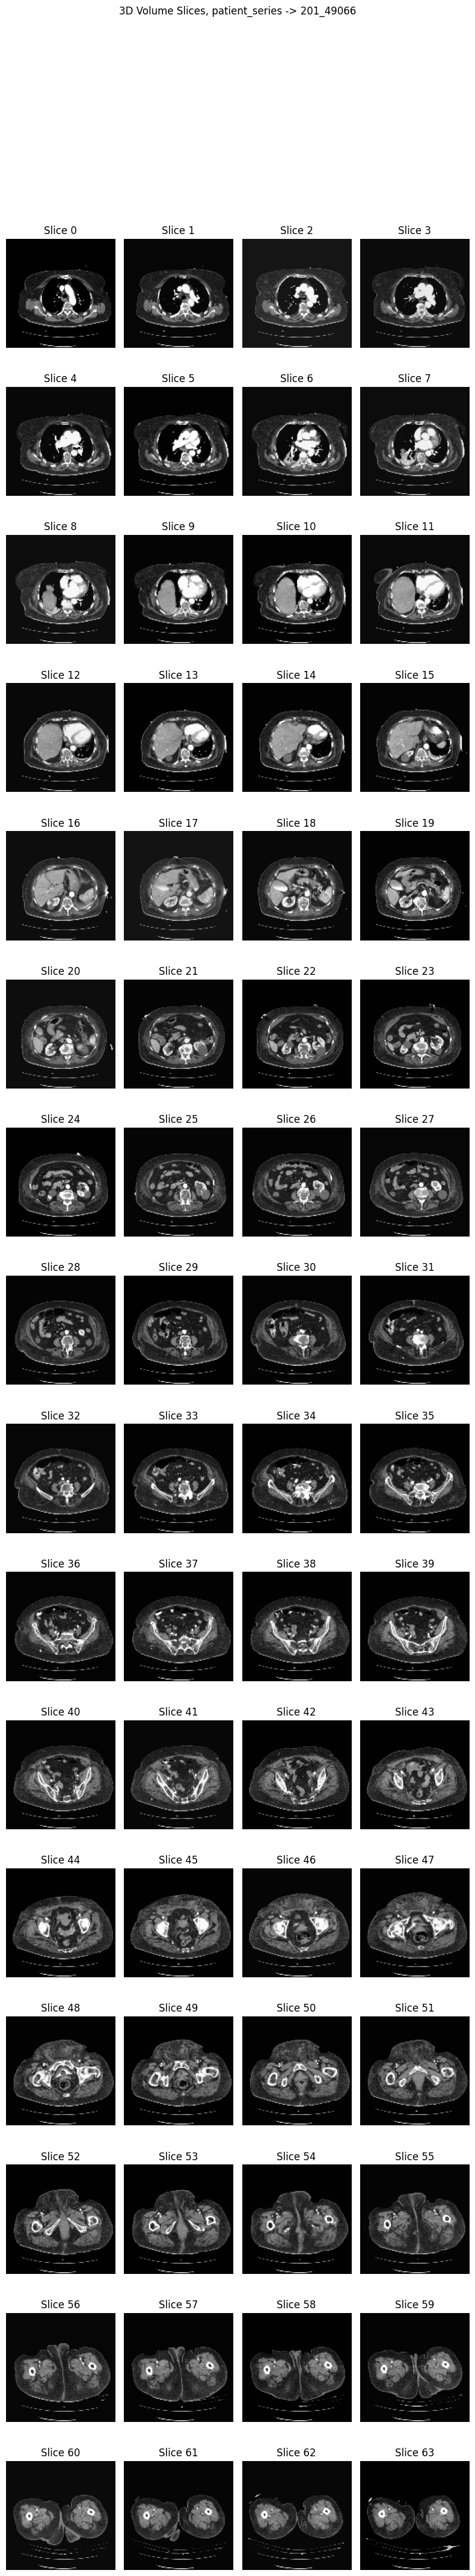

In [19]:
rows = 16  # Number of rows in the subplot grid
cols = 4  # Number of columns in the subplot grid
depth = 64

fig, axes = plt.subplots(rows, cols, figsize=(8, 44))
fig.suptitle(f'3D Volume Slices, patient_series -> 201_49066')

for d in range(depth):
    row = d // cols
    col = d % cols
    
    ax = axes[row, col]
    ax.imshow(X[:,:,d], cmap='gray')  # You can change the colormap if needed
    ax.set_title(f"Slice {d}")
    ax.axis('off')  # Turn off axis for cleaner visualization

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust the position of the suptitle

# Show the plot
plt.show()